In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.preprocessing import Imputer

import copy
import argparse

%matplotlib inline

In [28]:
ames_train = pd.read_csv('./datasets/train.csv')
ames_test = pd.read_csv('./datasets/test.csv')
ames_test_1 = pd.read_csv('./datasets/test.csv')
print(ames_train.shape)
print(ames_test.shape)

(2051, 81)
(879, 80)


In [29]:
ames_train['base_1st'] = ames_train['Total Bsmt SF'] * ames_train['1st Flr SF']
ames_test['base_1st'] = ames_test['Total Bsmt SF'] * ames_test['1st Flr SF']

In [30]:
ames_train['quality_year'] = ames_train['Overall Qual'] * ames_train['Year Built']
ames_test['quality_year'] = ames_test['Overall Qual'] * ames_test['Year Built']

In [31]:
ames_train['quality_sq_ft'] = ames_train['Overall Qual'] * ames_train['1st Flr SF']
ames_test['quality_sq_ft'] = ames_test['Overall Qual'] * ames_test['1st Flr SF']

In [32]:
ames_train['garage_area_cars'] = ames_train['Garage Area'] * ames_train['Garage Cars']
ames_test['garage_area_cars'] = ames_test['Garage Area'] * ames_test['Garage Cars']

In [33]:
ames_train['qual_neig'] = ames_train['Neighborhood'] * ames_train['Overall Qual']
ames_test['qual_neig'] = ames_test['Neighborhood'] * ames_test['Overall Qual']

In [34]:
ames_train['Quality_sq'] = ames_train['Overall Qual'] * ames_train['Overall Qual']
ames_test['Quality_sq'] = ames_test['Overall Qual'] * ames_test['Overall Qual']

In [35]:
ames_train['GLA_OQ'] = ames_train['Gr Liv Area'] * ames_train['Overall Qual']
ames_test['GLA_OQ'] = ames_test['Gr Liv Area'] * ames_test['Overall Qual']

In [47]:
ames_train['GLA_SQ'] = ames_train['Gr Liv Area'] * ames_train['Gr Liv Area']
ames_test['GLA_SQ'] = ames_test['Gr Liv Area'] * ames_test['Gr Liv Area']

In [50]:
ames_train['Yr_brm'] = ames_train['Year Built'] * ames_train['Year Remod/Add']
ames_test['Yr_brm'] = ames_test['Year Built'] * ames_test['Year Remod/Add']

In [51]:
ames_train['GLA_Bath'] = ames_train['Gr Liv Area'] * ames_train['Full Bath']
ames_test['GLA_Bath'] = ames_test['Gr Liv Area'] * ames_test['Full Bath']

In [37]:
# ames_train['neig_sq_ft'] = ames_train['Neighborhood'] * ames_train['1st Flr SF']
# ames_test['neig_sq_ft'] = ames_test['Neighborhood'] * ames_test['1st Flr SF']

In [38]:
# ames_train._get_numeric_data
ames_test.fillna(ames_test.mean(), inplace=True)
ames_test.fillna('no_value_reported', inplace=True)

In [39]:
ames_test.columns

Index(['Id', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
       'G

In [112]:
tested_col = [
            'Overall Qual',
            'Yr_brm',
            'Total Bsmt SF', 
            '1st Flr SF',
            'Gr Liv Area',
            'Full Bath',
            'TotRms AbvGrd',
            'garage_area_cars',
            'quality_year',
            'quality_sq_ft',
            'qual_neig',
            'Quality_sq',
            'GLA_OQ',
            'GLA_Bath',
            'Neighborhood',
            'Bldg Type',
            'Exterior 1st',
            
            
            ]

In [113]:
ames_train.corr()[['SalePrice']].sort_values('SalePrice', ascending=False)

,SalePrice
SalePrice,1.000000
GLA_OQ,0.837152
Quality_sq,0.825539
quality_year,0.806902
Overall Qual,0.800207
quality_sq_ft,0.792151
Gr Liv Area,0.697038
garage_area_cars,0.690671
GLA_Bath,0.682967
Garage Area,0.650270


In [114]:
corr_1 = ames_train[[
            'Overall Qual',
            'Yr_brm',
            'Total Bsmt SF', 
            '1st Flr SF',
            'Gr Liv Area',
            'Full Bath',
            'TotRms AbvGrd',
            'garage_area_cars',
            'quality_year',
            'quality_sq_ft',
            'qual_neig',
            'Quality_sq',
            'GLA_OQ',
            'GLA_Bath',
            'Neighborhood',
            'Bldg Type',
            'Exterior 1st',
            'SalePrice']].corr()
corr_1.shape

(14, 14)

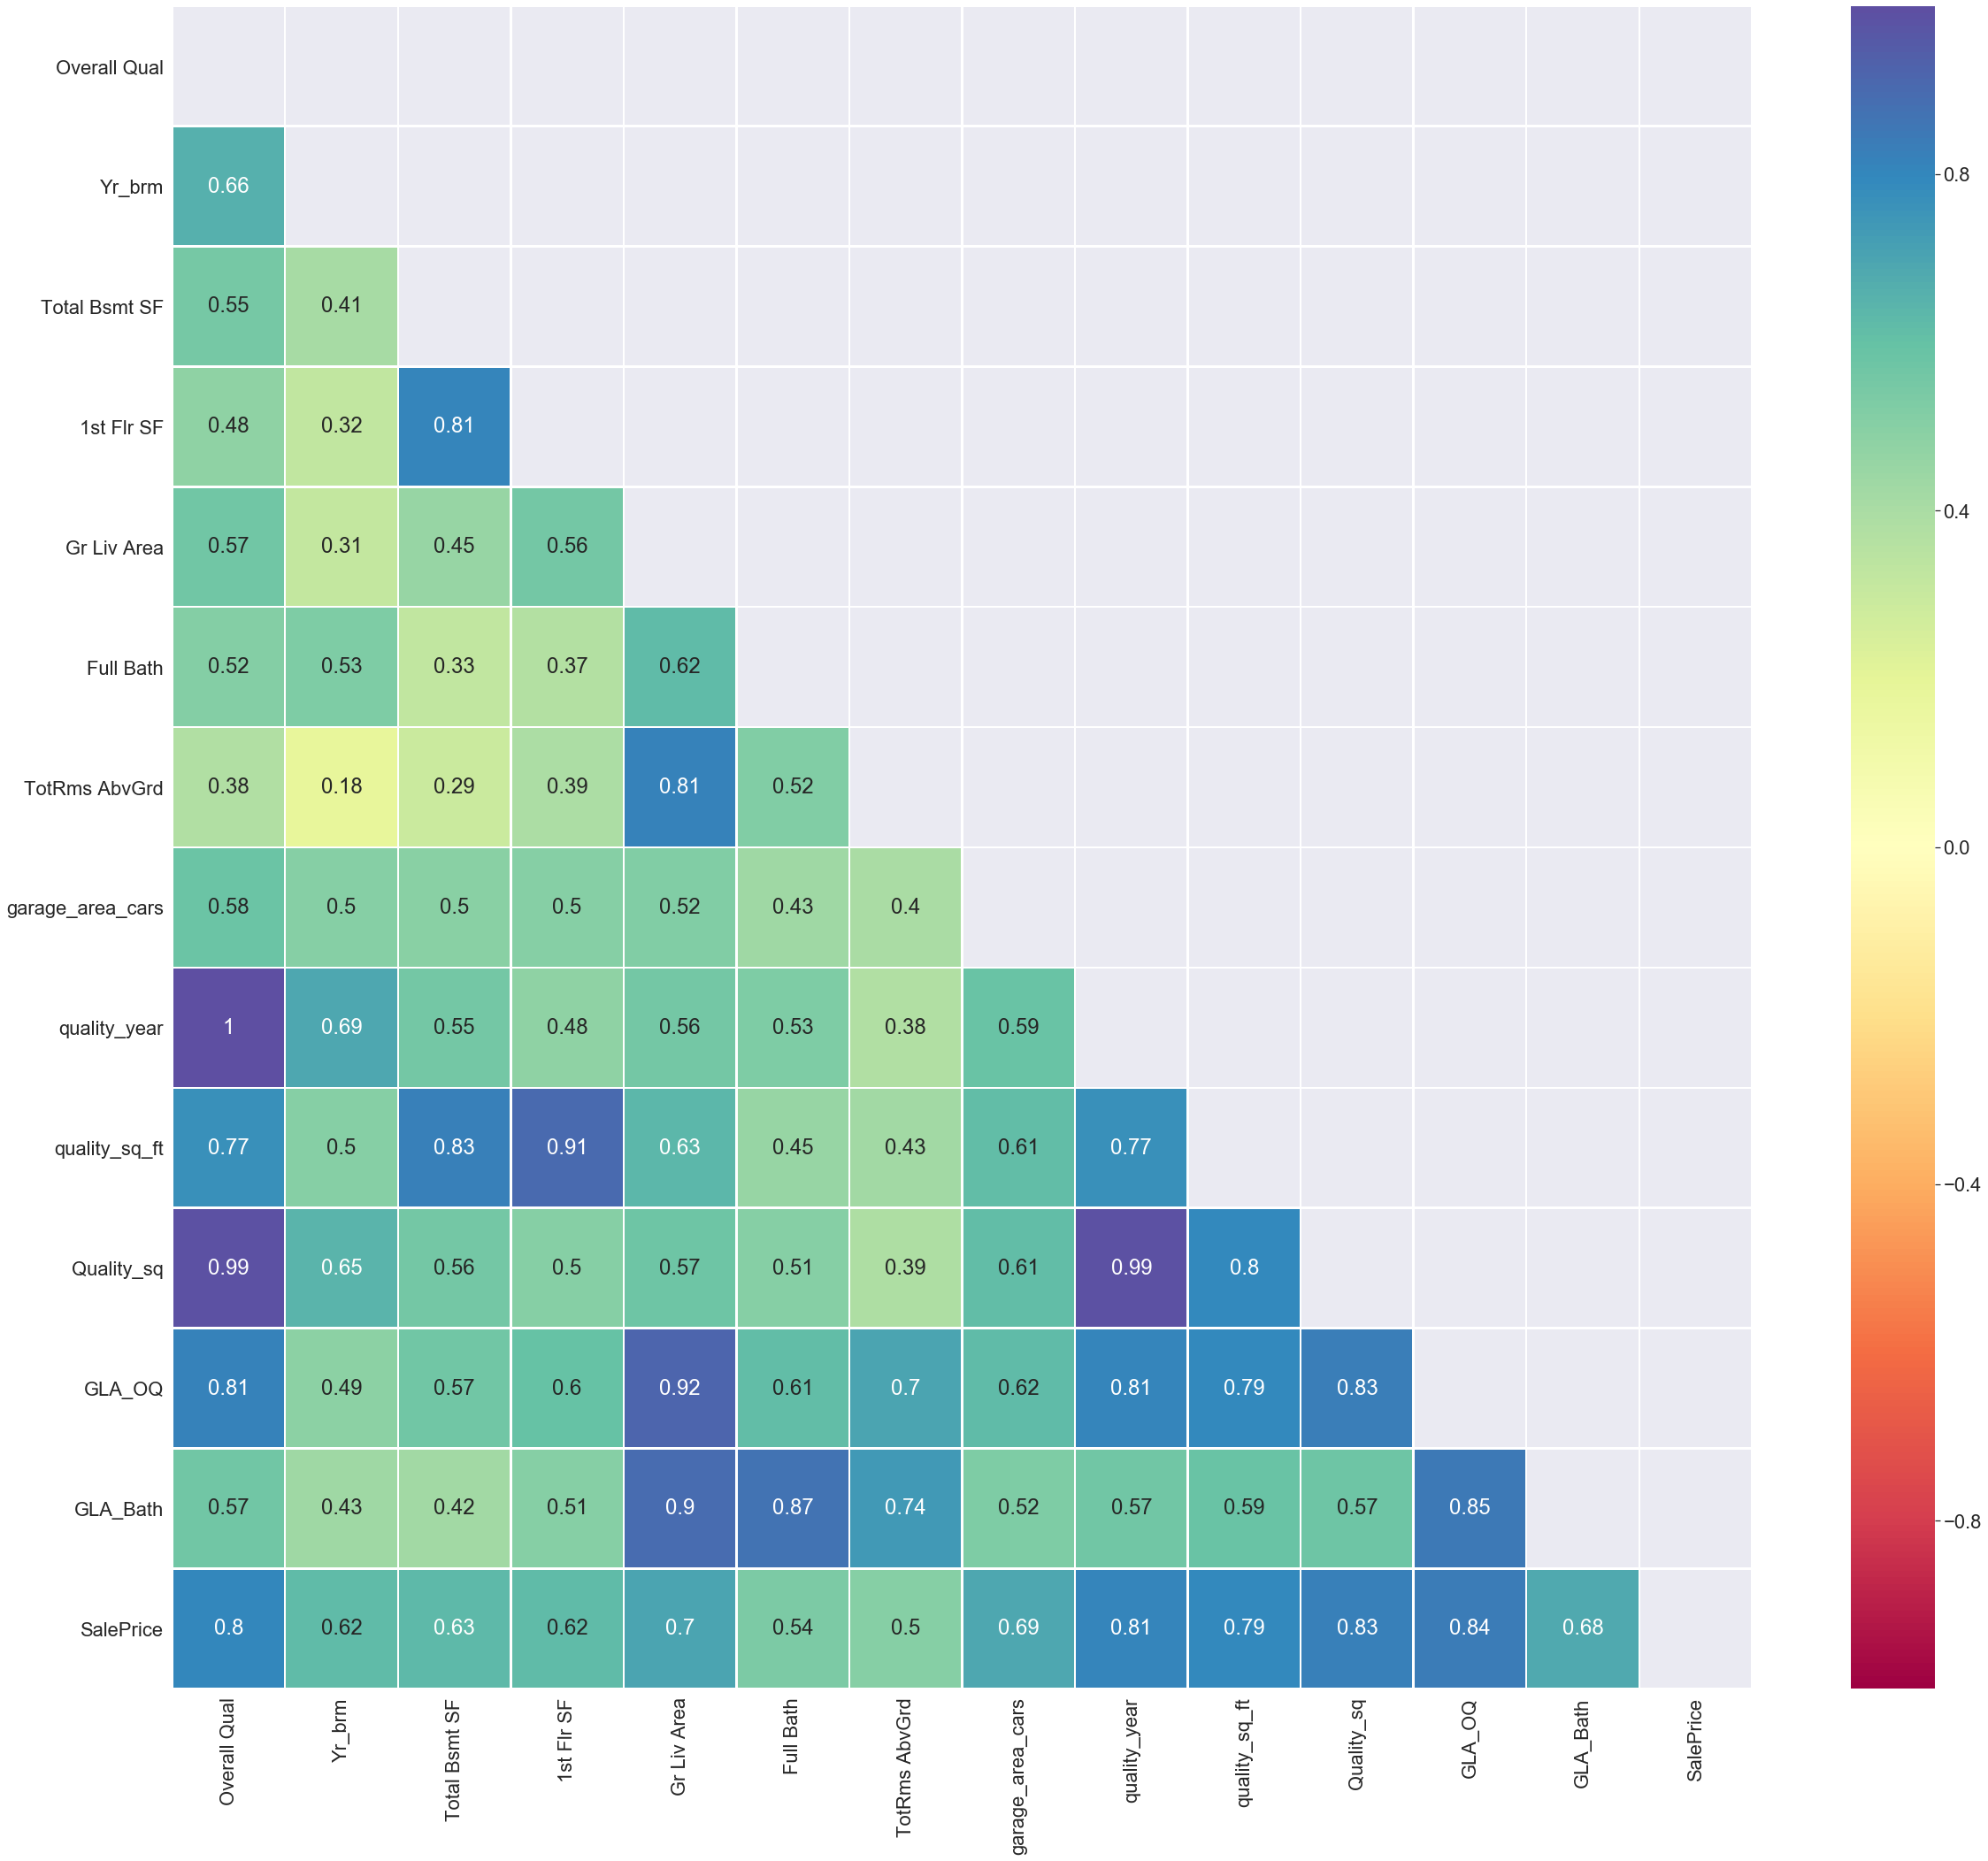

In [118]:
plt.figure(figsize = (40, 35))
plt.xticks(rotation=45)
mask = np.zeros_like(corr_1)
mask[np.triu_indices_from(mask)] = True
sns.set(font_scale = 2)
ax = sns.heatmap(corr_1, mask=mask, annot=True, cmap='Spectral', vmax=1, vmin=-1,
            square=False, linewidths=1.5,  cbar_kws={"shrink": 1.0}, xticklabels='auto')


In [ ]:
# # Creating a function that makes a power variable (feature) and puts that feature in a dataframe.
# def new_variable(series_1, series_2, series_name, df):
#     df[series_name] = series_1 * series_2
#     return df

In [108]:
def dropped_cols(df, tested_col):
    dropped_col = []
    for col in df:
        if col not in tested_col:
            dropped_col.append(col)
    return dropped_col  


def dummy_vars_list(df, tested_cols):
    dummy_vars_list = []
    for col in tested_cols:
        if df[col].dtype.name == 'object':
            dummy_vars_list.append(col)
    return dummy_vars_list            
    


def get_dummies(train, test, columns, drop_first=True,
                inplace=False):
    if not inplace:
        train = copy.deepcopy(train)
        test = copy.deepcopy(test)
        

    for column in columns:
        train_levels = set(train[column])
        test_levels = set(test[column])
        all_levels = sorted(train_levels.union(test_levels))
        if drop_first:
            all_levels = all_levels[1:]
        for level in all_levels:
            dummy_name = "%s_is_%s" % (column, level)
            train[dummy_name] = (train[column] == level) # Could be replaced with an if statement
            test[dummy_name] = (test[column] == level)
    train.drop(columns=columns, inplace=True)
    test.drop(columns=columns, inplace=True)

    
    # return only necessary if inplace=False
    return (train, test)

def check_compatibility(train, test):
    # assume compatible unless one of these checks fails
    if not (len(train.columns) == len(test.columns)):
        return False
    for column in train.columns:
        if not (column in test.columns):
            return False
    return True


def clean_data(train, test, columns_to_drop,
               columns_for_dummies, remove_na=True,
               drop_first=True, inplace=False):
    if not inplace:
        train = copy.deepcopy(train)
        test = copy.deepcopy(test)
  
    # inplace=True because if user called with inplace=False,
    # we already made a copy and aren't modifying his/her original
    train.drop(columns=columns_to_drop, inplace=True)
    test.drop(columns=columns_to_drop, inplace=True)
  

#     same reason as above for inplace=True
    if remove_na:
        train.dropna(inplace=True)
        test.dropna(inplace=True)


    (train, test) = get_dummies(train, test,
                                columns=columns_for_dummies,
                                drop_first=drop_first,
                                inplace=inplace)
    

    return (train, test)


###################

def patrick_clean_data(train_df, test_df, variables, remove_na=True, drop_first=True, inplace=False):
    columns_to_drop = dropped_cols(test_df, variables)
    dummy_columns = dummy_vars_list(test_df, variables)
    new_train, new_test = clean_data(train_df, test_df, 
                                     columns_to_drop, 
                                     dummy_columns, 
                                     remove_na=remove_na, 
                                     drop_first=drop_first, 
                                     inplace=inplace)
    
    y_col_name = []
    for col in new_train.columns:
        if col not in new_test.columns:
            y = new_train[col]
            y_col_name = col
    new_train = new_train.drop(y_col_name, axis=1)
    
    assert check_compatibility(new_train, new_test)
    
#     for column in new_test.columns: # Turn this on if I want to see what columns were made
#         print(column)

    return new_train, new_test, y

In [109]:
new_train, new_test, y = patrick_clean_data(ames_train, ames_test, tested_col)
print(new_test.shape)
print(new_train.shape)
print(y.shape)

(879, 169)
(2049, 169)
(2049,)


In [110]:
def metrics_summary(X, y, test_set, cv, k, scaled=True, poly=False):
    
    if poly!=poly:
        poly = PolynomialFeatures(degree=2, include_bias=False)
        X = poly.fit_transform(X)
        
    else:
        
        # Scaling our data
        ss = StandardScaler()
        X_sc = ss.fit_transform(X)
        test_sc = ss.transform(test_set)

        # Instantiating our models
        model = LinearRegression()
        lasso = LassoCV(cv=5)    
        ridge = RidgeCV(cv=5)

        # Fitting our models on non-scaled and scaled data
        model.fit(X,y)
        model.fit(X_sc, y)
        lasso.fit(X_sc, y)
        ridge.fit(X_sc, y)

        # Running the predictions on our model
        model_p = model.predict(X)
        model_pred = model.predict(X_sc)
        lasso_pred = lasso.predict(X_sc)
        ridge_pred = ridge.predict(X_sc)

        resids_lr = y - model_p
        resids_lr_sc = y - model_pred
        resids_lasso = y - lasso_pred
        resids_ridge = y - ridge_pred

        rss_lr = (resids_lr ** 2).sum()
        rss_lr_sc = (resids_lr_sc ** 2).sum()
        rss_lasso = (resids_lasso ** 2).sum()
        rss_ridge = (resids_ridge ** 2).sum()

        r_squared = (metrics.r2_score(y, model_p))
        adj_r2 = 1 - (1-r_squared)*((len(y)-1)/(len(y)-X.shape[k]-1))

        # Running cross value scores
        cvs = cross_val_score(model, X_sc, y, cv=cv).mean()
        cvs_l = cross_val_score(lasso, X_sc, y, cv=cv).mean()
        cvs_r = cross_val_score(ridge, X_sc, y, cv=cv).mean()

        print(f'RSS (Residual Sum of Squares) : {(rss_lr)}')
        print(f'MAE (Mean Absolute Error) : {(metrics.mean_absolute_error(y, model_p))}') 
        print(f'MSE (Mean Square Error) : {(metrics.mean_squared_error(y, model_p))}')
        print()
        print(f'Root MSE (Root Meen Square Error Linear Non-Scaled) : {(np.sqrt(rss_lr / len(model_p)))}')
        print(f'Root MSE (Root Meen Square Error Linear Scaled) : {(np.sqrt(rss_lr_sc / len(model_pred)))}')
        print(f'Root MSE (Root Meen Square Error Lasso) : {(np.sqrt(rss_lasso / len(lasso_pred)))}')
        print(f'Root MSE (Root Meen Square Error Ridge) : {(np.sqrt(rss_ridge / len(ridge_pred)))}')
        print()
        print(f'R\u00b2 : {(r_squared)}')
        print(f'Adjusted R\u00b2 : {(adj_r2)}')
        print()
        print(f'CVS (Cross Value Score LR) : {(cvs)}')
        print(f'CVS (Cross Value Score Lasso) : {(cvs_l)}')
        print(f'CVS (Cross Value Score Ridge) : {(cvs_r)}')

        model.fit(X_sc, y)
        model_pred_final = model.predict(test_sc)
        lasso.fit(X_sc, y)
        lasso_pred_final = lasso.predict(test_sc)
        ridge.fit(X_sc, y)
        ridge_pred_final = ridge.predict(test_sc)

        if (cvs > cvs_l) and (cvs > cvs_r):
            prediction = pd.DataFrame(model_pred_final, columns=['SalePrice']).to_csv('wd_prediction_11.csv')
        elif (cvs_l > cvs) and (cvs_l > cvs_r):
            prediction = pd.DataFrame(lasso_pred_final, columns=['SalePrice']).to_csv('wd_prediction_11.csv')
        elif (cvs_r > cvs_l) and (cvs_r > cvs):
            prediction = pd.DataFrame(ridge_pred_final, columns=['SalePrice']).to_csv('wd_prediction_11.csv')
        return prediction


In [111]:
metrics_summary(new_train, y, new_test, 5, 1, scaled=True, poly=False)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype bool, int64 were all converted to float64 by StandardScaler.
  if sys.path[0] == '':
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492:

RSS (Residual Sum of Squares) : 2.619649457316188e+41
MAE (Mean Absolute Error) : 1.058191170538312e+19
MSE (Mean Square Error) : 1.2785014432973099e+38

Root MSE (Root Meen Square Error Linear Non-Scaled) : 1.1307083811917687e+19
Root MSE (Root Meen Square Error Linear Scaled) : 24045.858006009348
Root MSE (Root Meen Square Error Lasso) : 25005.799121747004
Root MSE (Root Meen Square Error Ridge) : 24053.035436989278

R² : -2.036019517908867e+28
Adjusted R² : -2.2191420823189777e+28

CVS (Cross Value Score LR) : -2.2377315496257524e+26
CVS (Cross Value Score Lasso) : 0.8728100114136128
CVS (Cross Value Score Ridge) : 0.875511091619208
